In [5]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl# 

In [6]:
class Reaction:    #pythonのクラスはC言語で言う、構造体
    def __init__(self,name,rate,reactants,products):   #コンストラクタ、インスタンス生成のときに呼び出され、引数を受け取る。
        self.name=name
        self.rate=rate
        self.reactants=reactants    #[A,B]
        self.products=products      #[C,D]
        
        self.count={}   #よくわからん
        for sp in reactants:
            if sp in self.count:
                self.count[sp]-=1
            else:
                self.count[sp]=-1
        for sp in products:
            if sp in self.count:
                self.count[sp]+=1
            else:
                self.count[sp]=1
    
    def get_flux(self):        #クラス内の関数メソッド
        if callable(self.rate):#もしrateが関数だったら、
            return self.rate(self.reactants)    #関数self.rateの引数を渡す。
        val=self.rate     #k=1.0
        for s in self.reactants:   #関数でなければ
            val *=s.concentration       #v=k[a][b]...
        return val
    
    #def __repr__(self):
     #   return str(self.name)+":"+'+'.join([str(r) for r in self.reactants])+"-->"+'+'.join([str(r) for r in  self.products])

    def __str__(self):   #こっちだけでok
        return str(self.name)+":"+'+'.join([str(r) for r in self.reactants])+"-->"+'+'.join([str(r) for r in  self.products])
    
    def __repr__(self):
        return str(self)

In [7]:
class Species:  #物質の定義
    def __init__(self,name,concentration,diffusion, parameter= None):   #コンストラクタ：インスタンス生成の際に必ず呼び出される。初期化
        self.name=name
        self.init_conc = concentration
        self._concentration=concentration #2d   
        self.diffusion=diffusion
        self.parameter = parameter
        self.relevant_enzymes = []
    
    @property    #関数を変数として扱える。中身いじらないように。
    def concentration(self):
        return self._concentration
    
    @concentration.setter   #propertyを外から変更できるようにする。
    def concentration(self,v):   #定義し直し
        self._concentration = v
        if len(self._concentration.shape) > 0:
            self._concentration[self._concentration < 0] = 0
        elif self._concentration < 0:
            self._concentration = 0
        for e in self.relevant_enzymes:
            e.update_needed = True
        
    def __str__(self):    #print,str関数が呼び出されたらself.nameが返される。
        return self.name
    
    def __repr__(self):
        return str(self)
        

In [8]:
class Enzyme:
    def __init__(self, name, venz,Kenz):
        self.name = name
        self.venz = venz
        self.Kenz = Kenz #can be an array? Pol and Exo have multiple
        self.targets = {}
        self.update_needed = False
        self.sum = 0.0
        
    def register_target(self, species, Kval):
        self.targets[species] = Kval
        species.relevant_enzymes.append(self)
        self.update_needed = True
        
    def update_sum(self):
        self.sum = 0
        for s in self.targets:
            self.sum += s.concentration/self.targets[s]
        
    def activity(self, Kval):
        if self.update_needed:
            self.update_sum()
            self.update_needed = False
        return self.venz/(Kval*(1+self.sum))
    
    def rate(self, reactant, Kval):
        return self.activity(Kval)*reactant[0].concentration

In [9]:
class Edge:
    
    def __init__(self,type_name, template, input, output): #vertices:頂点の集合,ege:矢印の集合？(辞書形)
        self.type=type_name
        self.template=template  #ネットワークの頂点  
        self.input = input
        self.output=output   #会合定数
    
    
    

class ReactionFactory:   #ひな型
    
    #データを入れる領域 : コンストラクタ
    def __init__(self,name,vertices,kassoc = 0.2,extrastab=0.5, vpol=1050,vnick=80 ,vexo=300 
                 ,Kpol= 80, Kpolboth=5.5, Kpoldispl=5.0, Knick = 30,Kexos=440 ,Kexoext=150): #vertices:頂点の集合,ege:矢印の集合(辞書形)
        self.name=name
        self.vertices=vertices  #ネットワークの頂点
        self.id_num = 0
        self.kassoc = kassoc    #会合定数
        self.extrastab = extrastab #additional stability from being longer
        self.pol = Enzyme("pol",vpol,[Kpol,Kpolboth])
        self.nick = Enzyme("nick",vnick,[Knick])
        self.exo = Enzyme("exo", vexo, [Kexos, Kexoext])
        #self.kpol = kpol  #ポリメラーゼ
        #self.kpoldispl = kpoldispl #
        #self.knick = knick
        #self.kexo=kexo
        #self.kboth=kboth
        #self.Vm_nick=Vm_nick
        #self.Vm_pol=Vm_pol
        #self.Vm_poldispl=Vm_poldispl
        #self.Vm_exo=Vm_exo
        
        #処理の仕方(メソッド=関数）を書く領域、自分のデータを参照できる
    def  get_reactions(self, edge):    #egeからproductを推測？
        if(edge==None):   #edeg=[]の時？
            return None
        #reac = Reaction(,partial(mm_rate,Km=1.0/edge.params,vmax=1.0/beta),)
        #self.id_num += 1
        all_reactions = []
        if edge.type == "PEN":    #Nの自己増殖反応（自己触媒）
            #TODO edge datatype: type, template, input (list), output(list)
            #N+G->N+N+G
            #Nの増殖反応の場合、ege=(PEN,G,[N][N,N]) ってこと？
            #intermediate species 中間種
            
            temp_alone = edge.template# not very clean, but easier to read?   ①G?何を
            temp_in = Species(edge.template.name+"_in",0,edge.template.diffusion)#何か代入する必要ある？
            temp_out = Species(edge.template.name+"_out",0,edge.template.diffusion)
            temp_both = Species(edge.template.name+"_both",0,edge.template.diffusion)
            temp_ext = Species(edge.template.name+"_ext",0,edge.template.diffusion)
            int_species = [temp_in, temp_out,temp_both,temp_ext]  #テンプレートの進化系
            self.id_num += 1
            r1=Reaction(f"R{self.id_num}",self.kassoc,[edge.input[0],temp_alone],[temp_in])
            self.id_num += 1
            r2 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_alone],[temp_out])
            self.id_num += 1
            r3 = Reaction(f"R{self.id_num}",self.kassoc,[edge.input[0],temp_out],[temp_both])
            self.id_num += 1
            r4 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_in],[temp_both])
            self.id_num += 1
            # Backward reactions
            r5 = Reaction(f"R{self.id_num}",self.kassoc*edge.input[0].parameter,[temp_in],[edge.input[0],temp_alone])
            self.id_num += 1
            r6 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_alone],[temp_out])
            self.id_num += 1
            r7 = Reaction(f"R{self.id_num}",self.kassoc,[edge.input[0],temp_out],[temp_both])
            self.id_num += 1
            r8 = Reaction(f"R{self.id_num}",self.kassoc,[edge.output[0],temp_in],[temp_both])
            self.id_num += 1
           #Emzyme
            r9 = Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[0]),[temp_in],[temp_ext])
            #self.kpol->Vm_pol/Kpol*(1+temp_in.concentraion/Kpol+temp_both.concentraion/kboth)   
            self.id_num += 1
            r10 = Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[1]),[temp_both],[temp_ext,edge.output[0]])    #これはどの反応を指す？
            #self.kpolddispl->Vm_poldispl/Kpoldislp*(1+temp_in.concentraion/Kpoldispl+temp_both.concentraion/kboth)   ？？？kboth？？？
            self.id_num += 1
            r11 = Reaction(f"R{self.id_num}",lambda reacts: self.nick.rate(reacts,self.nick.Kenz[0]),[temp_ext],[temp_both])
            #self.nick->Vm_nick/knick+temp_ext.concentrtion
            
            all_reactions+=[r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11]
            
            if len(edge.input) > 1:   #③入力が2個以上の時inhibit??????
                #inhibitor　　　　   入力　出力をどう表現する？ inhubit=生成を妨げる
                #②inhibiterって例えば何？
                #TODO
                temp_inhib = Species(edge.template.name+"_inhib",0,edge.template.diffusion)
                int_species.append(temp_inhib)
                
                self.id_num += 1
                r12 = Reaction(f"R{self.id_num}",self.kassoc,[temp_in,edge.input[1]],[temp_inhib,edge.input[0]])
                self.id_num += 1
                r13 = Reaction(f"R{self.id_num}",self.kassoc,[temp_alone,edge.input[1]],[temp_inhib])
                self.id_num += 1
                r14 = Reaction(f"R{self.id_num}",self.kassoc,[temp_out,edge.input[1]],[temp_inhib,edge.output[0]])
                self.id_num += 1
                #TODO: reverse reactions
                r15= Reaction(f"R{self.id_num}",self.kassoc*edge.input[1].parameter,[temp_inhib],[temp_alone,edge.input[1]])
                
               
                all_reactions+=[r12,r13,r14,r15]
        
        
       # ege=(PP,P,[N],[P]) 
        if edge.type == "PP":       #N+P->P+P input [N] output [P]
            #Nもspecies作った方がいいよね？
            pred_alone = edge.template  # P
            pred_in =Species(edge.template.name+"_in",0,edge.template.diffusion)   #change
            pred_ext = Species(edge.template.name+"_ext",0,edge.template.diffusion)   #change
            int_species = [ pred_in, pred_ext]  #テンプレートの進化系
            self.id_num += 1
            r1 = Reaction(f"R{self.id_num}",self.kassoc*pred_alone.parameter,[edge.input[0],pred_alone],[pred_in])   #①Pはtemplete？??????
            self.id_num += 1
            # Backward reactions
            r2 = Reaction(f"R{self.id_num}",self.kassoc*edge.input[0].parameter,[pred_in],[edge.input[0],pred_alone])   #①Pはtemplete？??????
            self.id_num += 1
            #PP->P+P
            r3= Reaction(f"R{self.id_num}",self.kassoc*pred_alone.parameter*self.extrastab,[pred_ext],[pred_alone,pred_alone])   #extra_stab:inverse of hybridazation
            
            
            # TODO + reverse (hybridization)    BUT too rare
            #r4= Reaction(f"R{self.id_num}",kassoc*...,[pred_alone,pred_alone],[pred_ext])
            #self.id_num += 1
                      
            #Enzyme
            self.id_num += 1
            r4= Reaction(f"R{self.id_num}",lambda reacts: self.pol.rate(reacts,self.pol.Kenz[0]),[pred_in],[pred_ext])
           # 
            
            all_reactions+=[r1,r2,r3,r4]
            
        if edge.type == "Exo":    #これもtypeに含める N-> P-> 
            #TODO
            self.id_num += 1
            r1= Reaction(f"R{self.id_num}",lambda reacts: self.exo.rate(reacts,self.exo.Kenz[0]),[edge.input[0]],[])   #①Pはtemplete？??????
            #self.kexo→Vm_exo/kexo*(1+edge.input.concenration/kexo)
            int_species=[]
            all_reactions+=[r1]
            
        #N= Species("N",10,2.0, 10.0)  P= Species("P",10,2.0, 10.0)   Pの同一分離反応って無視できたっけ？PPでは考慮してない（R1）
        #int_species  is nothing
         #edge=Edge("Exo", , [N], [])   
        #edge=Edge("Exo", , [P], [])   
        return int_species, all_reactions    #中間生成物、全ての反応
    
       
                
    
    def __str__(self):
        return str(self.name)+":"+'+'.join([str(v) for v in self.vertices])+"-->"+'+'.join([str(r) for r in get_product(self.ege)])
    #N+G->N+N+G



                      
                      #a->B
                     # a→aa 自己触媒反応
                      #微分方程式を
                      #簡単なシステムをシミュ
                     # PEN
                    #  PP
                      

#ミカエリスメンテン exo
#アクティビティ

In [10]:
def get_total_rate(rate,reactants):   #反応物  rate:初期値                      
    if callable(rate):    #もしrateが呼び出し可能(=関数）なら                   
        return rate(reactants)    #このカッコ何？   mm_rate(reactants,Km,vmax)  
    val=rate    #valは初期値                                                    
    for s in reactants:
        val*=s.concentration   #反応物の濃度を全てかける。                      
    return val

def mm_rate(reactants,saturators= None,Km=1.0,vmax=1.0): #ミカエリス・メンテ\ン式v=vmax*濃度/(Km+濃度 
    conc = np.product(np.array([reactant.concentration for reactant in reactants]),axis=0)             
    concsat = np.product(np.array([reactant.concentration for reactant in saturators]),axis=0) if saturators else conc   #後置if文 
    return vmax*conc/(Km+concsat)


In [11]:
def discrete_laplacian(M):    #端っこの処理がわからないけど......               
    """Get the discrete Laplacian of matrix M"""

    #変換                                                                       
    l=M.shape[0]+2    #(3,3)                                                    
    #print(l)                                                                   
    N=np.zeros((l,l))
    #print(N)                                                                   
    for i in range(l-2):
        for j in range(l-2):
            N[i+1,j+1]=M[i,j]
    #print(N)                                                                   
    #端っこの処理                                                               
    L = -4*N
    L += np.roll(N, (0,-1), (0,1)) # right neighbor                             
    L += np.roll(N, (0,+1), (0,1)) # left neighbor                              
    L += np.roll(N, (-1,0), (0,1)) # top neighbor   
    L += np.roll(N, (+1,0), (0,1)) # bottom neighbor                            

    #戻す                                                                       
    R=np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            R[i,j]=L[i+1,j+1]

    return R


In [12]:

def compute(t,y,species,reactions):#二次元に変える   tは実数,yはNumpy配列(初期値）)                                                                           
    yprime = np.zeros(y.shape)   #y＝(3,32,32)
    eq = {}
    for i,s in enumerate(species):      #0,N    1,P,    2,G    
        s.concentration = y[i]      #P.concentration=y[1]                       
        eq[s.name] = i            #eq={'N':0 ,'P':1 ,'G':2  }辞書     
        # count if react with saturated enzyme (e.g. exo)
    for r in reactions:   #r1,r2,r3,r4
        flux = r.get_flux()     #速度v                                                                                        
        for s in r.count:   #r.count={N:2 ,P:1, G:0}  辞書
            yprime[eq[s.name]] += r.count[s]*flux     #y'[0]+=1*flux,  化学反応による変化   fluxのとこ？
    if len(y.shape) > 1:
        yprime += np.array([species[i].diffusion*discrete_laplacian(v) for i, v in enumerate(y)])   #最後に拡散反応による変化  ここ要らない
    return yprime 

In [13]:
from scipy.integrate import solve_ivp

#まず定数を仮定
beta=0.087
delta=0.39
l=4.0
g0=2.5
n0=1
p0=0.1

def f(t,y,beta, l, delta):
    # y[0] -> g, y[1] -> n, y[2] -> p
    nprime=y[0]*y[1]/(1+beta*y[0]*y[1])-y[2]*y[1]-l*delta*y[1]/(1+y[2])+1e-6
    pprime=y[2]*y[1]-delta*y[2]/(1+y[2])
    return [0,nprime,pprime]


#そもそも常微分方程式じゃなくない？

([G1_in, G1_out, G1_both, G1_ext, G1_inhib], [R1:N+G1-->G1_in, R2:N+G1-->G1_out, R3:N+G1_out-->G1_both, R4:N+G1_in-->G1_both, R5:G1_in-->N+G1, R6:N+G1-->G1_out, R7:N+G1_out-->G1_both, R8:N+G1_in-->G1_both, R9:G1_in-->G1_ext, R10:G1_both-->G1_ext+N, R11:G1_ext-->G1_both, R12:G1_in+I-->G1_inhib+N, R13:G1+I-->G1_inhib, R14:G1_out+I-->G1_inhib+N, R15:G1_inhib-->G1+I])


([G2_in, G2_out, G2_both, G2_ext], [R16:N+G2-->G2_in, R17:M+G2-->G2_out, R18:N+G2_out-->G2_both, R19:M+G2_in-->G2_both, R20:G2_in-->N+G2, R21:M+G2-->G2_out, R22:N+G2_out-->G2_both, R23:M+G2_in-->G2_both, R24:G2_in-->G2_ext, R25:G2_both-->G2_ext+M, R26:G2_ext-->G2_both])


([G3_in, G3_out, G3_both, G3_ext], [R27:M+G3-->G3_in, R28:I+G3-->G3_out, R29:M+G3_out-->G3_both, R30:I+G3_in-->G3_both, R31:G3_in-->M+G3, R32:I+G3-->G3_out, R33:M+G3_out-->G3_both, R34:I+G3_in-->G3_both, R35:G3_in-->G3_ext, R36:G3_both-->G3_ext+I, R37:G3_ext-->G3_both])


([], [R38:N-->])


([], [R39:M-->])


([], [R40:I-->])




AttributeError: 'AxesSubplot' object has no attribute 'plt'

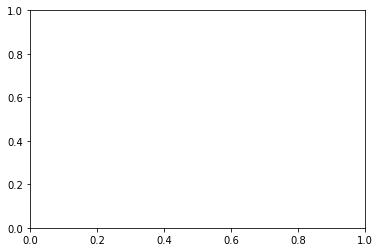

In [15]:
#changed from here##############################
import matplotlib.pyplot as plt
# N->N autocatalyze reaction
#ランダムに濃度設定する？
count=0   

#
for i in range(5):  
    for j in range(5):
        for k in range(5):
            for l in range(5):
                count=count+1  #number of loop
                G1 = Species("G1",i,1.0, 10.0)    #名前、濃度、拡散、パラメーター(安定性)
                G2 = Species("G2",j,1.0, 10.0)
                G3 = Species("G3",k,1.0, 10.0)
                N= Species("N",l,2.0, 100.0)
                M =  Species("M",0,2.0, 10.0)
                I =  Species("I",0,2.0, 0.1)
                #ここの数値を変える？
                species = [N,M,I]
                edge1=Edge("PEN", G1, [N,I], [N])   #N->N自己触媒　　   input[0],input[1]
                edge2 = Edge("PEN", G2, [N], [M])  #N->M N->Pも同じ？
                edge3 = Edge("PEN", G3, [M], [I])
                edges = [edge1,edge2,edge3]
                for s in species:
                    edges.append(Edge("Exo",None,[s],[]))
                species += [G1,G2,G3]
                reactionfactory=ReactionFactory("Oligator",species)   #インスタンス変数
                reactions = []
                for edge in edges:
                    all_gen = reactionfactory.get_reactions(edge)
                    print(all_gen)
                    species += all_gen[0]
                    reactions += all_gen[1]
                    print("\n")
                args=( species, reactions)    #Species Reaction
                
                res = solve_ivp(compute,[0,300],[s.init_conc for s in species],args=args)    #微分方程式をとく。関数f,t、初期値、Species Reaction?????
                #solve_ivp(関数、時間、[A0、B0、C0、,,,](species,reactions))

                fig = plt.figure()
                ax = plt.subplot(111)
                ax.plt(res.t,(res.y).T)    #これはただこの関数を試しただけ  時間を横軸に。yって何？初期値？
                plot.savefig(count+":G1,G2,G3,N="+i,j,k,l+".png")
                #画像を保存
                #タイトルにパラメータと一緒に保存
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                # Put a legend to the right of the current axis
                ax.legend([s.name for s in species], loc='center left', bbox_to_anchor=(1, 0.5))

                #振動するように変更する

In [18]:
res.y[7]

array([0.00000000e+00, 1.78482462e-03, 1.95016151e-02, ...,
       6.78909243e-06, 6.71685269e-06, 6.79453687e-06])

In [58]:
reactions

[R1:N+G1-->G1_in,
 R2:N+G1-->G1_out,
 R3:N+G1_out-->G1_both,
 R4:N+G1_in-->G1_both,
 R5:G1_in-->N+G1,
 R6:N+G1-->G1_out,
 R7:N+G1_out-->G1_both,
 R8:N+G1_in-->G1_both,
 R9:G1_in-->G1_ext,
 R10:G1_both-->G1_ext+N,
 R11:G1_ext-->G1_both,
 R12:G1_in+I-->G1_inhib+N,
 R13:G1+I-->G1_inhib,
 R14:G1_out+I-->G1_inhib+N,
 R15:G1_inhib-->G1+I,
 R16:N+G2-->G2_in,
 R17:M+G2-->G2_out,
 R18:N+G2_out-->G2_both,
 R19:M+G2_in-->G2_both,
 R20:G2_in-->N+G2,
 R21:M+G2-->G2_out,
 R22:N+G2_out-->G2_both,
 R23:M+G2_in-->G2_both,
 R24:G2_in-->G2_ext,
 R25:G2_both-->G2_ext+M,
 R26:G2_ext-->G2_both,
 R27:M+G3-->G3_in,
 R28:I+G3-->G3_out,
 R29:M+G3_out-->G3_both,
 R30:I+G3_in-->G3_both,
 R31:G3_in-->M+G3,
 R32:I+G3-->G3_out,
 R33:M+G3_out-->G3_both,
 R34:I+G3_in-->G3_both,
 R35:G3_in-->G3_ext,
 R36:G3_both-->G3_ext+I,
 R37:G3_ext-->G3_both]

In [27]:
#今は使わない。0次元を試したい
def integrate_euler(species,reactions,max_time= 100, dt=1e-3):        #1/1000   
    t = 0
    all_y = []
    y = np.zeros((len(species),*species[0].concentration.shape))   #N,P,Gの3つで（３、３２、３２）
    for i,s in enumerate(species):
        y[i] = copy.copy(species[i].concentration)                                                           
    while t<max_time:
        all_y.append(copy.copy(y))
        y += compute(t,y,species,reactions)*dt    #dtあたりの濃度の変化         
        t += dt
        #draw(y)     #毎秒表示                                                  
    return all_y


In [29]:
from qdpy import algorithms,containers,benchmarks,plots
from qdpy.base import ParallelismManager
import math

from scipy.signal import find_peaks



In [30]:
#これは使わない


def eval_fun_pp(indiv, scale=100.0, scale_reac = 10.0, max_time=15,size=50): 
    try:     #例外処理　　　エラーが起こるとexceptの処理にスキップ！(０による除算が行われると)                                                                 
        n=Species("N",np.zeros((size,size)),indiv[3])# Speciesクラスのインスンス(引数name,concentration,diffusion)                                          
        #preyのの濃度の設定  ウサギ                                             
        p=Species("P",np.zeros((size,size)),indiv[4])# Speciesクラスのインスタンス(引数name,concentration,diffusion)                                          
        #predaterの濃度   狐                                                    

        g=Species("G",np.zeros((size,size)),indiv[5])   #grass  あれ？草は拡散しないよね？                                                                    

        for i in range(30):
            for j in range(30):
                n.concentration[i,j]=scale*indiv[0] 
        for i in range(10):
            for j in range(10):
                p.concentration[i,j]=scale*indiv[1]     #0<indiv<1              
        for i in range(size):
            for j in range(size):
                g.concentration[i,j]=scale*indiv[2]

        beta = scale_reac*indiv[6]    #10.0*beta                                
        lbda = scale_reac*indiv[7]    #らむだ 
        delta = scale_reac*indiv[8]    #gamma                                   
        #(self,name,rate,reactants,products)   rate:速さのこと                  
        r1=Reaction("r1",partial(mm_rate,Km=1.0/beta,vmax=1.0/beta),[g,n],[g,n,n])#　　reactionクラス???                                                       
        r2=Reaction("r2",1.0,[n,p],[p,p])     #???                              
        r3=Reaction("r3",partial(mm_rate,saturators=[p],Km=1.0,vmax=lbda*delta),[n],[])    #preyのdeath  はん                                                  
        r4=Reaction("r4",partial(mm_rate,vmax=delta),[p],[])

        species = [n,p,g]
        reactions = [r1,r2,r3,r4]
        res = integrate_euler(species,reactions,max_time=max_time)   #all_y    \res[0],res[1].res[2]    それぞれn,p,gの2D                                       
        res_array = np.array([val[0] for val in res])    #n(ウサギの分布だけres_array                                                                          
        cell_num = np.product(res_array[-1].shape)   #size*size 32*32           
        fitness=np.sum(res_array[-1])/(cell_num*np.max(res_array))   #max_time時点でのウサギの濃度の合計/cell_num(32*32)*ウサギの最高濃度  normalization標準\\化                                                                              
        #features=[np.std(res_array[-1])/np.max(res_array), indiv[6]]           
        features=[indiv[0], indiv[6]]
    except:     #0による除算が行われたら、  
        fitness=0
        features=[-1,-1]
    return [fitness],[*features] #[評価値]、[max_timeでの標準偏差/ウサギの最高濃度  ,beta=1/k]    

In [28]:

len(np.float64(1).shape)

0